<div style="width: 400px; height: 160px;">
    <img src="rplogo_small.png" width="100%" height="100%" align="left">
</div>

###     TIPP - AAI Assignement (Deep Learning Fundamentals)<br>Due Date: 21 February 2020
###     Submitted By: <u>KOAY</u> SENG TIAN<br>Email: sengtian@yahoo.com


## Question 2 (Training)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# for reproducibility
np.random.seed(1337)

# set verbose=0 to skip the charts and other information
# set verbose=1 to see chart and other information
#verbose=0
verbose=1

# the datasets are stored in the data directory
data_dir = os.path.join(os.getcwd(), 'data')

# full path to datatraining.txt
datatraining_file = os.path.join(data_dir, 'datatraining.txt')

In [2]:
train_df = pd.read_csv(datatraining_file)
train_df['date']= pd.to_datetime(train_df['date']) 

if verbose==1:
    print(train_df.shape)
    print()
    print('-----HEAD-----')
    print(train_df.head(5))
    print()
    print('-----TAIL-----')
    print(train_df.tail(5))
    print()
    print(train_df.dtypes)

(8143, 7)

-----HEAD-----
                 date  Temperature  Humidity  Light     CO2  HumidityRatio  \
1 2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
2 2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
3 2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
4 2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
5 2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

   Occupancy  
1          1  
2          1  
3          1  
4          1  
5          1  

-----TAIL-----
                    date  Temperature  Humidity  Light         CO2  \
8139 2015-02-10 09:29:00        21.05   36.0975  433.0  787.250000   
8140 2015-02-10 09:29:59        21.05   35.9950  433.0  789.500000   
8141 2015-02-10 09:30:59        21.10   36.0950  433.0  798.500000   
8142 2015-02-10 09:32:00        21.10   36.2600  433.0  820.333333   
8143 2015-02-10 09:33:00        21.10   36.2000  

In [3]:
train_df.sort_values(by='date', inplace=True, ascending=True)

if verbose==1:
    print('The time series starts from: ', train_df.date.min())
    print('The time series ends on: ', train_df.date.max())
    print()

The time series starts from:  2015-02-04 17:51:00
The time series ends on:  2015-02-10 09:33:00



In [4]:
if verbose==1:
    print('Columns having ZERO values:')
    print(train_df.eq(0).sum())
    print()

# Light has 5160 zero values - no issue since the lights were switched off when there were no occupacy
# Occupancy has 6414 zero values - no issue since '0' represents unoccupied room

Columns having ZERO values:
date                0
Temperature         0
Humidity            0
Light            5160
CO2                 0
HumidityRatio       0
Occupancy        6414
dtype: int64



In [5]:
import mycharts

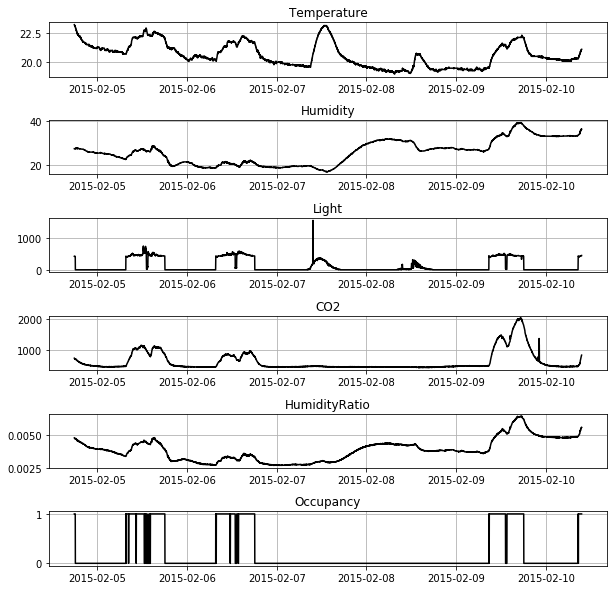

In [6]:
if verbose==1:
    mycharts.chart01(train_df.columns[1:], train_df, 'black')   

In [7]:
#set the date as index
train_df = train_df.set_index('date')

In [8]:
if verbose==1:
    print('-----HEAD-(Before Shifting)----')
    print(train_df.head())
    print()
    print('-----TAIL-(Before Shifting)----')
    print(train_df.tail())
    print()
    print(train_df.dtypes)

-----HEAD-(Before Shifting)----
                     Temperature  Humidity  Light     CO2  HumidityRatio  \
date                                                                       
2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

                     Occupancy  
date                            
2015-02-04 17:51:00          1  
2015-02-04 17:51:59          1  
2015-02-04 17:53:00          1  
2015-02-04 17:54:00          1  
2015-02-04 17:55:00          1  

-----TAIL-(Before Shifting)----
                     Temperature  Humidity  Light         CO2  HumidityRatio  \
date                                                                           
2015-02-10 

In [9]:
# shift the data 'backward' by 1
# so as to perform future occupancy forecasting 
train_df.Occupancy = train_df.Occupancy.shift(-1)

In [10]:
# drop the last row as occupancy is Nan
train_df.drop(train_df.tail(1).index, inplace=True)
train_df.Occupancy = train_df.Occupancy.astype('int64')

In [11]:
if verbose==1:
    # the below prints are meant for integrity 
    # checking i.e. compare before and after shifting
    print('Last row was dropped')
    print('Shape=', train_df.shape)
    print()
    print('-----HEAD-(After Shifting)----')
    print(train_df.head())
    print()
    print('-----TAIL-(After Shifting)----')
    print(train_df.tail())
    print()
    print(train_df.dtypes)

Last row was dropped
Shape= (8142, 6)

-----HEAD-(After Shifting)----
                     Temperature  Humidity  Light     CO2  HumidityRatio  \
date                                                                       
2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

                     Occupancy  
date                            
2015-02-04 17:51:00          1  
2015-02-04 17:51:59          1  
2015-02-04 17:53:00          1  
2015-02-04 17:54:00          1  
2015-02-04 17:55:00          1  

-----TAIL-(After Shifting)----
                     Temperature  Humidity  Light         CO2  HumidityRatio  \
date                                                  

In [12]:
X = train_df.iloc[:,  : -1].copy().to_numpy()
y = train_df.iloc[:, -1].copy().to_numpy()

In [13]:
if verbose==1:
    print('X shape=', X.shape)
    print('y shape=', y.shape)
#     print(X[0])
#     print(y[0])

X shape= (8142, 5)
y shape= (8142,)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# reshape due to LSTM's samples, timestep and features
X_train = X_train.reshape(-1, 1, 5)
X_test = X_test.reshape(-1, 1, 5)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
if verbose==1:
    print('X_train and X_test reshaped for LSTM:')
    print('X_train shape=', X_train.shape)
    print('X_test shape=', X_test.shape)

X_train and X_test reshaped for LSTM:
X_train shape= (5699, 1, 5)
X_test shape= (2443, 1, 5)


In [16]:
from keras import models
from keras import layers

data_dim = X_train.shape[2]
timesteps = X_train.shape[1]

if verbose==1:
    print('Data dim={}, Time steps={}\n'.format(data_dim, timesteps))

network = models.Sequential()
network.add(layers.LSTM(9, return_sequences=True, input_shape=(timesteps, data_dim)))
network.add(layers.Dense(5, activation='sigmoid'))
network.add(layers.LSTM(3))
network.add(layers.Dense(1, activation='sigmoid'))

network.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

network.summary()

Using TensorFlow backend.


Data dim=5, Time steps=1





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 9)              540       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 5)              50        
_________________________________________________________________
lstm_2 (LSTM)                (None, 3)                 108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = network.fit(X_train, y_train, epochs=15, batch_size=40, verbose=1, shuffle=True, validation_data=(X_test, y_test))

print()
test_loss, test_acc = network.evaluate (X_test, y_test)
print('\ntest_acc:', test_acc)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5699 samples, validate on 2443 samples
Epoch 1/15





5699/5699 [==============================] - 2s 382us/step - loss: 0.2317 - acc: 0.7287 - val_loss: 0.2076 - val_acc: 0.7880
Epoch 2/15
5699/5699 [==============================] - 1s 102us/step - loss: 0.1864 - acc: 0.7877 - val_loss: 0.1692 - val_acc: 0.7880
Epoch 3/15
5699/5699 [==============================] - 1s 116us/step - loss: 0.1542 - acc: 0.7877 - val_loss: 0.1329 - val_acc: 0.7880
Epoch 4/15
5699/5699 [==============================] - 1s 118us/step - loss: 0.1092 - acc: 0.7931 - val_loss: 0.0845 - val_acc: 0.8792
Epoch 5/15
5699/5699 [==============================] - 1s 111us/step - loss: 0.0703 - acc: 0.9351 - val_loss: 0.0544 - val_acc: 0.9582
Epoch 6/15
5699/5699 [==============================] - 1s 122us/step - loss: 0.0473 - acc: 0.9621 - val_loss: 0.0366 - val_acc: 0.9709
Epoch 7/15
5699/5699 [============

In [18]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(loss_values) + 1)

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

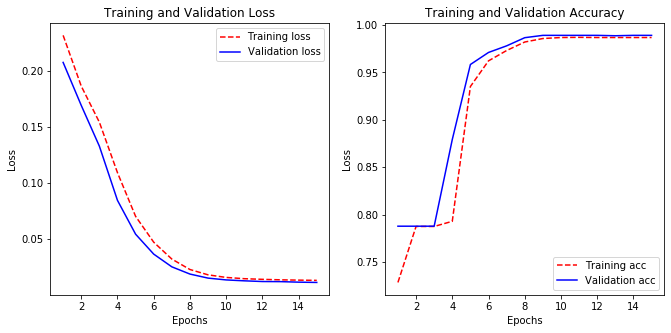

In [19]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# draw chart to show validation vs training losses
ax1.plot(epochs, loss_values, 'r--', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.title.set_text('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# draw chart to show validation vs training accuracy
ax2.plot(epochs, acc_values, 'r--', label='Training acc')
ax2.plot(epochs, val_acc_values, 'b', label='Validation acc')
ax2.title.set_text('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

In [20]:
# save model and scaler for later access
import pickle

save_dir = os.path.join(os.getcwd(), 'model')
model_filename = 'model.pkl'
scaler_filename = 'scaler.pkl'

with open(os.path.join(save_dir, model_filename), 'wb+') as model_file:
    pickle.dump(network, model_file)
    print('Save model.')
    
with open(os.path.join(save_dir, scaler_filename), 'wb+') as scaler_file:
    pickle.dump(scaler, scaler_file)
    print('Save scaler.')

Save model.
Save scaler.
